### Load the trainned prunned model

In [1]:
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow_model_optimization.sparsity.keras import strip_pruning

2025-08-04 22:24:06.775169: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 22:24:06.777678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 22:24:06.806330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 22:24:06.806350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 22:24:06.806386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
import math
from collections import defaultdict

def reuse_percentage_to_factors(model, serial_pct: float = 1.0):
    """
    Map each Dense / Conv / DepthwiseConv layer to a valid hls4ml ReuseFactor.

    Parameters
    ----------
    model       : Keras / QKeras model
    serial_pct  : float in [0, 1]
        1.0 → completely serial (largest legal reuse factor)
        0.0 → completely parallel (ReuseFactor = 1)

    Returns
    -------
    dict {layer_name: reuse_factor}
    """
    from tensorflow.keras.layers import Dense, Conv2D, DepthwiseConv2D
    from qkeras import QDense, QConv2D, QDepthwiseConv2D

    if not 0.0 <= serial_pct <= 1.0:
        raise ValueError("serial_pct must be in [0, 1]")

    reuse = {}

    
    def legal_divisor(n, candidate):
        """Decrease candidate until it cleanly divides n."""
        while candidate > 1 and n % candidate:
            candidate -= 1
        return max(1, candidate)
    

    for layer in model.layers:
        if isinstance(layer, (Dense, QDense)):
            total = layer.input_shape[-1] * layer.units          # Nin × Nout

        elif isinstance(layer, (Conv2D, QConv2D)):
            kh, kw   = layer.kernel_size
            cin      = layer.input_shape[-1]
            cout     = layer.filters
            total    = kh * kw * cin * cout                      # per-pixel MACs

        elif isinstance(layer, (DepthwiseConv2D, QDepthwiseConv2D)):
            kh, kw   = layer.kernel_size
            cin      = layer.input_shape[-1]
            total    = kh * kw * cin                             # per-pixel MACs

        else:
            continue  # no MACs → nothing to tune

        #   serial_pct = 1.0  → target_rf = total  (most serial)
        #   serial_pct = 0.0  → target_rf = 1      (fully parallel)
        target_rf = int(round(total * serial_pct))
        target_rf = min(max(1, target_rf), total)

        # Snap downward to the nearest divisor so that total % rf == 0
        rf = legal_divisor(total, target_rf)

        reuse[layer.name] = rf
        print(f"{layer.name:20s}  MACs={total:6d}  ReuseFactor={rf}")

    return reuse


In [3]:
import math
from collections import defaultdict

def reuse_factors_with_serial_pct(model):
    """
    For each Dense / Conv / DepthwiseConv layer in a model, print all valid reuse factors 
    and their corresponding serial_pct (ReuseFactor / total MACs).

    Parameters
    ----------
    model : Keras / QKeras model
    """
    from tensorflow.keras.layers import Dense, Conv2D, DepthwiseConv2D
    from qkeras import QDense, QConv2D, QDepthwiseConv2D

    def get_total_macs(layer):
        if isinstance(layer, (Dense, QDense)):
            return layer.input_shape[-1] * layer.units
        elif isinstance(layer, (Conv2D, QConv2D)):
            kh, kw = layer.kernel_size
            cin = layer.input_shape[-1]
            cout = layer.filters
            return kh * kw * cin * cout
        elif isinstance(layer, (DepthwiseConv2D, QDepthwiseConv2D)):
            kh, kw = layer.kernel_size
            cin = layer.input_shape[-1]
            return kh * kw * cin
        else:
            return None  # Unsupported layer

    def get_divisors(n):
        """Return all positive integers that divide n."""
        return sorted({i for i in range(1, n + 1) if n % i == 0})

    for layer in model.layers:
        total_macs = get_total_macs(layer)
        if total_macs is None:
            continue

        print(f"\nLayer: {layer.name} ({layer.__class__.__name__}) - Total MACs: {total_macs}")
        print(f"{'ReuseFactor':>12} | {'SerialPct':>10}")
        print("-" * 27)

        for rf in get_divisors(total_macs):
            serial_pct = rf / total_macs
            print(f"{rf:12d} | {serial_pct:10.4f}")


In [4]:



model_dir = 'models'
model_path = f'{model_dir}/quantized_pruned_cnn_model.h5'
co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude


qmodel = tf.keras.models.load_model(model_path, custom_objects=co)
qmodel = strip_pruning(qmodel)

In [5]:
qmodel.summary()

Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 26, 26, 8)         113       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None, 11, 11, 12)        925       
 chnorm)                                                         
                                                                 
 conv_act_1 (QActivation)    (None, 11, 11, 12)        0    

In [6]:
reuse_factors_with_serial_pct(qmodel)


Layer: fused_convbn_0 (QConv2DBatchnorm) - Total MACs: 72
 ReuseFactor |  SerialPct
---------------------------
           1 |     0.0139
           2 |     0.0278
           3 |     0.0417
           4 |     0.0556
           6 |     0.0833
           8 |     0.1111
           9 |     0.1250
          12 |     0.1667
          18 |     0.2500
          24 |     0.3333
          36 |     0.5000
          72 |     1.0000

Layer: fused_convbn_1 (QConv2DBatchnorm) - Total MACs: 864
 ReuseFactor |  SerialPct
---------------------------
           1 |     0.0012
           2 |     0.0023
           3 |     0.0035
           4 |     0.0046
           6 |     0.0069
           8 |     0.0093
           9 |     0.0104
          12 |     0.0139
          16 |     0.0185
          18 |     0.0208
          24 |     0.0278
          27 |     0.0312
          32 |     0.0370
          36 |     0.0417
          48 |     0.0556
          54 |     0.0625
          72 |     0.0833
          96 |     

In [7]:
project_folder = 'Projects_Reuse_Factor_Analysis'
project_path = f'{project_folder}/Optimized_Packed'
backend = 'Vitis'
default_precision = 'ap_fixed<16,6>'
part = 'xczu5ev-sfvc784-1-i'
project_name = 'optimized_packed_cnn'
RF=0.0
Packed = True

In [8]:
import hls4ml
import utils.plotting as plotting

# Generate base HLS config
hls_config = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity='name',
    backend=backend,
    default_precision=default_precision
)

# Set model-level precision
hls_config['Model']['Precision'] = default_precision

# Force Resource strategy globally
for lname, lcfg in hls_config['LayerName'].items():
    lcfg['Strategy'] = 'Latency'

# Inject computed reuse factors
reuse_factors = reuse_percentage_to_factors(qmodel, serial_pct=RF)
for lname, factor in reuse_factors.items():
    if lname in hls_config['LayerName']:
        hls_config['LayerName'][lname]['ReuseFactor'] = factor
        
    #if "dense" in lname:
    #    hls_config['LayerName'][lname]['Strategy'] = "Resource"
        
    else:
        print(f"Warning: Layer {lname} not found in HLS config")

plotting.print_dict(hls_config)


# Convert and compile
hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config,
    backend=backend,
    output_dir=project_path,
    part=part,
    io_type='io_stream',
    clock_period=5,
    trace=True,
    project_name=project_name,
)
hls_model.compile()


/home/theodoros/miniconda3/envs/ai_on_fpga/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 12]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 12]], output shape: [None, 11, 11, 12]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 12]], output shape: [None, 5, 5, 12]
Layer name: flatten_1, layer type: Reshape, input shapes: [[None, 5, 5, 12]], output shape: [None, 300]
Layer name: dense_0, layer type: QDense, input

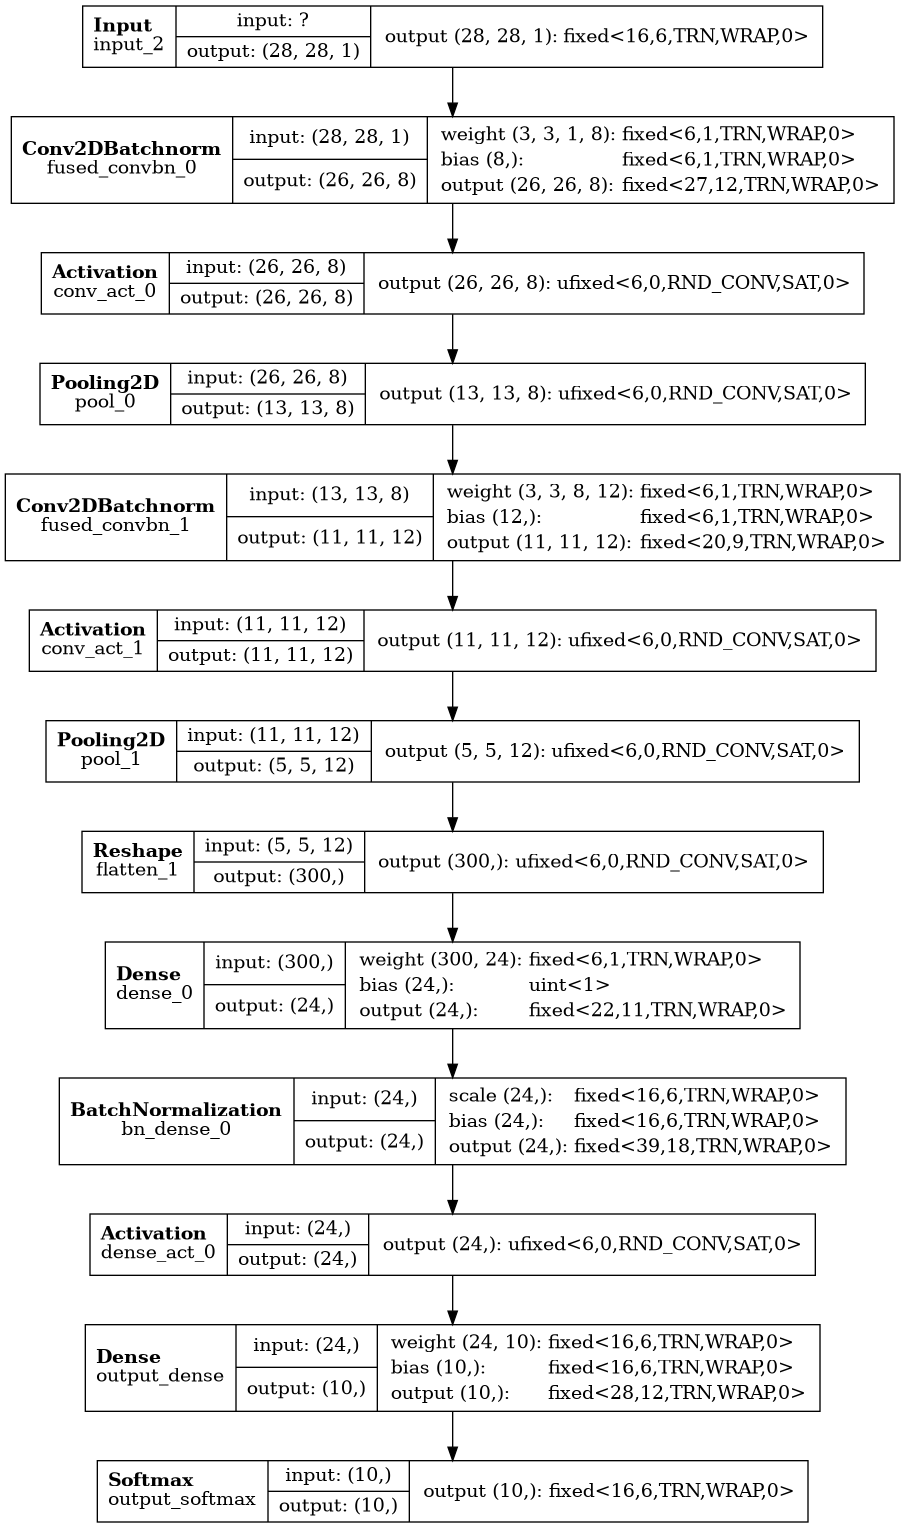

In [9]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [10]:
from template_injector import TemplateInjector

injector = TemplateInjector(template_dir="templates")

injector.inject(
    project_dir=project_path,
    project_name=project_name,
    force=True,  # or False to skip existing files
    packed=Packed
)

✅ Injected: Projects_Reuse_Factor_Analysis/Optimized_Packed/firmware/optimized_packed_cnn_stream.cpp
✅ Injected: Projects_Reuse_Factor_Analysis/Optimized_Packed/firmware/optimized_packed_cnn_stream.h
✅ Injected: Projects_Reuse_Factor_Analysis/Optimized_Packed/optimized_packed_cnn_test.cpp
📁 Copied: build_tb.py → Projects_Reuse_Factor_Analysis/Optimized_Packed/build_tb.py
📁 Copied: compute_performance.py → Projects_Reuse_Factor_Analysis/Optimized_Packed/compute_performance.py
📁 Copied: build_prj.tcl → Projects_Reuse_Factor_Analysis/Optimized_Packed/build_prj.tcl
📁 Copied: golden_preds.py → Projects_Reuse_Factor_Analysis/Optimized_Packed/golden_preds.py


In [11]:
import os
pwd = os.getcwd()
print(f"Current working directory: {pwd}")
build = True

Current working directory: /home/theodoros/Projects/AI_ON_FPGA


In [12]:
if build:
    os.system(f"cd {pwd}/{project_path} && python build_tb.py && vitis-run --mode hls --tcl build_prj.tcl && python compute_performance.py && python golden_preds.py")

2025-08-04 22:24:16.017185: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 22:24:16.018562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 22:24:16.041899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 22:24:16.041923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 22:24:16.041949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

✅ Quantized data written to 'tb_data/tb_input_features.dat' and 'tb_data/tb_output_predictions.dat'

****** vitis-run v2024.2 (64-bit)
  **** SW Build 5239630 on 2024-11-10-11:19:46
  **** Start of session at: Mon Aug  4 22:24:20 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

  **** HLS Build v2024.2 5238294
Sourcing Tcl script '/home/theodoros/Projects/AI_ON_FPGA/Projects_Reuse_Factor_Analysis/Optimized_Packed/build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project -reset optimized_packed_cnn_prj 
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Projects/AI_ON_FPGA/Projects_Reuse_Factor_Analysis/Optimized_Packed/optimized_packed_cnn_prj'.
INFO: [HLS 200-1510] Running: set_top optimized_packed_cnn_stream 
INFO: [HLS 200-1510] Running: add_files firmware/optimized_packed_cnn_stream.cpp -cflags -std=c++14 
INFO: [HLS 200-10] Adding design file 'firmware/optimized_packed_cnn_

2025-08-04 22:31:38.769906: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 22:31:38.771413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 22:31:38.797414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 22:31:38.797441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 22:31:38.797468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

313/313 [==============================] - 1s 2ms/step
Saved all 10,000 quantized inputs to 'golden_inputs.npy' and predictions to 'golden_preds.npy'
